In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init
done


In [3]:
import sys
sys.path.append(r"D:\workspace\TradeX\ezMoney")
from http_request import build_http_request
from data_class import category_rank_class
def get_ranked_category_infos(date_key, except_is_ppp = True, except_is_track = False, gap = 10):
    # build_http_request.check_user_alive()
    categoryRankList = category_rank_class.build_category_rank_sort_list(date_key)
    block_rank_list = []
    for item in categoryRankList:
        if item == None:
            continue
        if item.stockType == 'industry':
            isPpp = item.isPpp
            num = item.num
            numChange = item.numChange
            isTrack = item.isTrack
            stockCode = item.categoryCode
            r  = {
                'isPpp': isPpp,
                'num': num,
                'numChange': numChange,
                'isTrack': isTrack,
                'blockCode': stockCode
            }
            block_rank_list.append(r)
        if item.blockRankList == None:
            continue
        block_rank_list.extend(item.blockRankList)

    if except_is_ppp:
        block_rank_list = [item for item in block_rank_list if not item['isPpp']]
    if except_is_track:
        block_rank_list = [item for item in block_rank_list if not item['isTrack']]

    sorted_block_rank_list = sorted(block_rank_list, key=lambda x: (-x['num'], -x['numChange']))
    rank_dict = {}
    prev_num = None
    current_rank = 1

    for idx, item in enumerate(sorted_block_rank_list):
        code = item['blockCode']
        num = item['num']

        if idx == 0:
            # 第一个元素直接赋初始排名
            rank_dict[code] = current_rank
            prev_num = num
            continue

        delta = 0
        diff = prev_num - num

        # 判断差值规则
        if abs(diff) <= 0.0001:
            delta = 0
        else:
            if gap == 0:
                delta = 1
            else:
                if diff > gap:
                    delta = int(diff // gap) + 1
                else:
                    delta = 1
        current_rank += delta
        rank_dict[code] = current_rank
        prev_num = num
    return rank_dict

In [4]:


hd_pct = 0.001

strategy_name = '放宽低吸前3'
days = 10
#胜率最高
params = [
              {
        "filtered": True,
        "fx_filtered": True,
        "topn": 1,
        "top_fx": 2,
        "top_cx": 15,
        "only_fx": True,
        "enbale_industry": False,
        "empty_priority": False
      }
        ]

filter_count = 0
filter_amount = 10000000
gap = 0
rank_filter = True

In [5]:
def get_first_tick_trade_amount(stock_code, datekey):
    import datetime
    import pandas as pd

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 20, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 26, 0)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.tail(1)

    amount = min_time_row['amount']

    if len(amount) == 1:
        real_amount = amount.item()
    else:
        raise Exception(f"{stock_code}-{datekey}")

    return real_amount

def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        raise Exception(f"{stock_code}-{datekey}")

    return last_price_real

In [6]:
all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock

def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
                
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
            
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | (group['max_industry_code_rank'] <= top_cx))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



In [7]:
param0 = params[0]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

In [8]:
import sqlite3
# months = ['202502']
months = ['202409', '202410', '202411', '202412', '202501', '202502', '202503']
# months = ['202409', '202410']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (sub_strategy_name = '%s') and stock_rank <= %s " % (db_name, strategy_name, days)
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,1544,2024-09-25,低吸,放宽低吸前3,600550.XSHG,保变电气,1,"000035.BKDL,000037.BKDL,000004.BKDL,000017.BKDL","885520.DDBK,885571.DDBK,885514.DDBK,886021.DDB...",980474.ZHBK,...,放宽低吸前3,-29.90,-29.90,65,-16.81,-34.76,51,"{""9A0001"": {""realShortLineScore"": 77.46, ""real...","{""000015.BKDL"": {""categoryCode"": ""000015.BKDL""...",2025-02-15 17:58:27
1,1584,2024-09-26,低吸,放宽低吸前3,001236.XSHE,弘业期货,1,"000038.BKDL,000018.BKDL,000015.BKDL,000017.BKDL","885694.DDBK,886021.DDBK,885413.DDBK,885570.DDB...","980360.ZHBK,980341.ZHBK",...,放宽低吸前3,-10.67,19.23,59,-5.85,-30.44,48,"{""9A0001"": {""realShortLineScore"": 89.66, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-02-15 17:59:28
2,1585,2024-09-26,低吸,放宽低吸前3,600830.XSHG,香溢融通,2,"000023.BKDL,000010.BKDL,000004.BKDL,000017.BKDL","885869.DDBK,885924.DDBK,886021.DDBK,885595.DDB...","980360.ZHBK,980353.ZHBK",...,放宽低吸前3,-10.67,19.23,59,-5.85,-30.44,48,"{""9A0001"": {""realShortLineScore"": 89.66, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-02-15 17:59:28
3,1616,2024-09-27,低吸,放宽低吸前3,000158.XSHE,常山北明,1,"000012.BKDL,000015.BKDL,000016.BKDL,000034.BKD...","885459.DDBK,885514.DDBK,885517.DDBK,885980.DDB...","980753.ZHBK,980366.ZHBK",...,放宽低吸前3,92.02,102.69,27,68.29,5.07,25,"{""9A0001"": {""realShortLineScore"": 104.45, ""rea...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-02-15 18:00:38
4,1617,2024-09-27,低吸,放宽低吸前3,600318.XSHG,新力金融,2,"000023.BKDL,000010.BKDL,000015.BKDL","885740.DDBK,886016.DDBK,885456.DDBK","980360.ZHBK,980341.ZHBK",...,放宽低吸前3,92.02,102.69,27,68.29,5.07,25,"{""9A0001"": {""realShortLineScore"": 104.45, ""rea...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-02-15 18:00:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1681,2025-03-11,低吸,放宽低吸前3,001268.XSHE,联合精密,1,,,,...,放宽低吸前3,-19.11,-105.53,33,-42.89,-17.25,39,"{""9A0001"": {""realShortLineScore"": 52.58, ""real...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-03-12 08:01:33
140,1991,2025-03-13,低吸,放宽低吸前3,002760.XSHE,凤形股份,1,"000023.BKDL,000013.BKDL","885739.DDBK,885802.DDBK,885700.DDBK",980365.ZHBK,...,放宽低吸前3,-53.06,-168.23,53,-19.65,-21.80,36,"{""9A0001"": {""realShortLineScore"": 15.77, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-03-14 08:01:29
141,2137,2025-03-14,低吸,放宽低吸前3,603359.XSHG,东珠生态,1,"000012.BKDL,000008.BKDL,000024.BKDL,000011.BKD...","885701.DDBK,885520.DDBK,885991.DDBK,885986.DDB...","980338.ZHBK,980346.ZHBK,980756.ZHBK",...,放宽低吸前3,-48.88,-7.83,58,-48.55,-32.97,48,"{""9A0001"": {""realShortLineScore"": 52.83, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-17 08:01:20
142,2360,2025-03-17,低吸,放宽低吸前3,603206.XSHG,嘉环科技,1,"000012.BKDL,000003.BKDL,000035.BKDL,000011.BKD...","886100.DDBK,885919.DDBK,885461.DDBK,885956.DDB...","980753.ZHBK,980376.ZHBK",...,放宽低吸前3,-105.38,7.37,71,-81.71,-10.44,68,"{""9A0001"": {""realShortLineScore"": 51.76, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-18 08:01:16


In [ ]:
if rank_filter:
    for idx, row in combined_df.iterrows():
        block_category = row['block_category']
        block_codes = row['block_codes']
        industry_code = row['industry_code']
        date_key = row['date_key']
        ranked_block_dict = get_ranked_category_infos(date_key, gap = gap)
        min_rank = 100
        if not block_codes:
            continue
        else:
            for block_code in block_codes.split(','):
                if block_code in ranked_block_dict:
                    rank_this = ranked_block_dict[block_code]
                    min_rank = min(min_rank, rank_this)
        if not industry_code:
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank
            continue
        else:
            i_min_rank = 100
            for i_code in industry_code.split(','):
                if i_code in ranked_block_dict:
                    rank_this = ranked_block_dict[i_code]
                    min_rank = min(min_rank, rank_this)
                    i_min_rank = min(i_min_rank, rank_this)
                    combined_df.loc[idx, 'max_industry_code_rank'] = i_min_rank
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank


In [ ]:
combined_df = combined_df.reset_index(drop=True)

In [ ]:
combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == '低吸']

In [ ]:
pd.set_option('display.max_columns', None)
combined_df.tail(10)

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at
130,3119,2025-02-26,低吸,放宽低吸前3,601177.XSHG,杭齿前进,3,"000024.BKDL,000035.BKDL,000023.BKDL,000015.BKD...","885743.DDBK,885571.DDBK,885740.DDBK,886021.DDB...",980365.ZHBK,2,3,3,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0.0,290.49,348.40,0.0,-2.00,17.15,19.25,-1.0,18.40,18.19,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,58.47,-24.18,16,-3.28,-2.58,39,2025-02-28 17:32:41
131,3168,2025-02-27,低吸,放宽低吸前3,002591.XSHE,恒大高新,1,"000012.BKDL,000003.BKDL,000026.BKDL,000035.BKD...","885743.DDBK,885996.DDBK,885936.DDBK,885890.DDB...","980355.ZHBK,980364.ZHBK",4,13,27,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,260.82,391.79,0.0,-2.00,5.40,5.38,-1.0,5.38,5.24,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,103.68,12.14,18,10.79,-5.72,30,2025-02-28 17:33:43
132,556,2025-03-04,低吸,放宽低吸前3,605100.XSHG,华丰股份,1,"000003.BKDL,000024.BKDL,000023.BKDL,000035.BKD...","885869.DDBK,885887.DDBK,885706.DDBK,885946.DDB...",980365.ZHBK,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,436.78,453.39,0.0,-4.35,22.00,25.30,-1.0,25.00,25.32,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,-114.88,-88.23,55,-57.32,-37.21,58,2025-03-05 08:01:39
133,723,2025-03-05,低吸,放宽低吸前3,603496.XSHG,恒为科技,1,"000012.BKDL,000003.BKDL,000035.BKDL,000006.BKD...","885459.DDBK,885517.DDBK,885700.DDBK,885311.DDB...",980366.ZHBK,2,1,18,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1617.48,934.42,0.0,-8.06,34.68,35.85,-1.0,36.05,37.39,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,-116.34,-42.70,61,-55.01,-18.57,60,2025-03-06 08:01:29
134,974,2025-03-06,低吸,放宽低吸前3,003033.XSHE,征和工业,1,"000024.BKDL,000027.BKDL,000033.BKDL","885706.DDBK,885929.DDBK,886061.DDBK,885997.DDBK",980372.ZHBK,2,9,36,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,358.25,484.25,0.0,-3.76,39.47,43.58,-1.0,42.17,46.94,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,-108.09,-4.53,59,-49.20,-0.86,54,2025-03-07 03:13:13
135,975,2025-03-06,低吸,放宽低吸前3,601177.XSHG,杭齿前进,2,"000024.BKDL,000035.BKDL,000023.BKDL,000015.BKD...","885743.DDBK,885571.DDBK,885740.DDBK,886021.DDB...",980365.ZHBK,2,19,29,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0.0,331.33,341.12,0.0,-3.41,20.12,22.91,-1.0,21.54,23.68,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,-108.09,-4.53,59,-49.20,-0.86,54,2025-03-07 03:13:13
136,1322,2025-03-07,低吸,放宽低吸前3,605066.XSHG,天正电气,1,"000023.BKDL,000035.BKDL,000011.BKDL,000007.BKD...","885869.DDBK,885783.DDBK,885921.DDBK,885919.DDB...",980474.ZHBK,3,6,26,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0.0,299.30,285.71,0.0,-2.98,9.77,9.07,-1.0,8.76,8.36,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,132.92,71.80,3,15.32,13.29,18,2025-03-10 08:01:32
137,1491,2025-03-10,低吸,放宽低吸前3,603700.XSHG,宁水集团,1,"000008.BKDL,000026.BKDL,000023.BKDL,000006.BKD...","885692.DDBK,886072.DDBK,885312.DDBK,885806.DDB...",980365.ZHBK,3,5,5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1623.17,1018.25,0.0,-9.92,12.71,12.70,-1.0,12.12,12.35,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,93.00,-20.32,11,-22.40,-28.20,36,2025-03-11 08:01:36
138,1492,2025-03-10,低吸,放宽低吸前3,001368.XSHE,通达创智,2,"000021.BKDL,000012.BKDL,000026.BKDL,000018.BKD...","885899.DDBK,885840.DDBK,885598.DDBK,885617.DDB...",980373.ZHBK,1,2,25,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0.0,426.80,376.33,0.0,-0.54,22.18,22.33,-1.0,21.82,22.04,-1.0,-1.0,-1.0,-1.0,0,0,9G

In [ ]:

combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

过滤股票 002718.SZ 日期 2024-10-15 过滤原因： first_tick_amount 6694897.0
过滤股票 002629.SZ 日期 2024-10-25 过滤原因： first_tick_amount 7162038.0
过滤股票 605069.SH 日期 2024-11-01 过滤原因： first_tick_amount 8529519.0
过滤股票 603137.SH 日期 2024-12-16 过滤原因： first_tick_amount 6140310.0
过滤股票 001277.SZ 日期 2025-01-03 过滤原因： first_tick_amount 7608570.0
过滤股票 002591.SZ 日期 2025-02-27 过滤原因： first_tick_amount 9039600.0
过滤股票 001368.SZ 日期 2025-03-10 过滤原因： first_tick_amount 8969592.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24168\2790183003.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)


,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-25,1544,低吸,放宽低吸前3,600550.XSHG,保变电气,1,"000035.BKDL,000037.BKDL,000004.BKDL,000017.BKDL","885520.DDBK,885571.DDBK,885514.DDBK,886021.DDB...",980474.ZHBK,2,11,23,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0.0,738.59,492.22,0.0,-4.63,10.50,9.91,-1.0,9.60,9.47,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,-29.90,-29.90,65,-16.81,-34.76,51,2025-02-15 17:58:27,253876949.0,-0.085714,-0.086714,-0.098095,-0.099095
2024-09-26,1584,低吸,放宽低吸前3,001236.XSHE,弘业期货,1,"000038.BKDL,000018.BKDL,000015.BKDL,000017.BKDL","885694.DDBK,886021.DDBK,885413.DDBK,885570.DDB...","980360.ZHBK,980341.ZHBK",1,7,9,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0.0,285.51,267.92,0.0,-7.46,10.55,11.69,-1.0,11.60,12.06,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,-10.67,19.23,59,-5.85,-30.44,48,2025-02-15 17:59:28,32112090.0,0.099526,0.098526,0.143128,0.142128
2024-09-27,1616,低吸,放宽低吸前3,000158.XSHE,常山北明,1,"000012.BKDL,000015.BKDL,000016.BKDL,000034.BKD...","885459.DDBK,885514.DDBK,885517.DDBK,885980.DDB...","980753.ZHBK,980366.ZHBK",1,1,2,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0.0,285.58,225.42,0.0,-1.54,12.16,11.99,-1.0,12.25,13.19,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,92.02,102.69,27,68.29,5.07,25,2025-02-15 18:00:38,214036672.0,0.007401,0.006401,0.084704,0.083704
2024-11-01,213,低吸,放宽低吸前3,002725.XSHE,跃岭股份,2,"000026.BKDL,000018.BKDL,000027.BKDL,000031.BKD...","885924.DDBK,885840.DDBK,885775.DDBK,885431.DDB...",980372.ZHBK,2,4,24,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,192.03,229.17,0.0,-7.81,15.35,14.99,-1.0,13.49,13.49,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,132.91,0.31,3,170.42,-2.64,3,2025-02-15 18:24:38,30667151.0,-0.121173,-0.122173,-0.121173,-0.122173
2024-11-04,317,低吸,放宽低吸前3,000821.XSHE,京山轻机,2,"000038.BKDL,000035.BKDL,000023.BKDL,000018.BKD...","885878.DDBK,885467.DDBK,885517.DDBK,885564.DDB...","980365.ZHBK,980474.ZHBK",1,1,11,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,782.96,775.42,0.0,-10.02,13.20,14.08,-1.0,13.96,14.12,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,119.77,-13.14,1,155.93,-13.22,3,2025-02-15 18:26:11,90755438.0,0.057576,0.056576,0.069697,0.068697
2024-11-05,402,低吸,放宽低吸前3,002272.XSHE,川润股份,2,"000035.BKDL,000023.BKDL,000011.BKDL,000006.BKD...","885571.DDBK,885996.DDBK,885425.DDBK,885854.DDB...","980365.ZHBK,980474.ZHBK",2,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,525.02,599.05,0.0,-8.85,12.15,12.83,-1.0,12.46,11.91,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,123.18,3.41,1,162.14,-2.15,2,2025-02-15 18:27:30,45471375.0,0.025514,0.024514,-0.019753,-0.020753
2024-11-06,502,低吸,放宽低吸前3,002583.XSHE,海能达,1,"000008.BKDL,000026.BKDL,000018.BKDL,000023.BKD...","885840.DDBK,885757.DDBK,885521.DDBK,885574.DDB...",980376.ZHBK,1,6,51,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,227.03,272.97,0.0,-3.63,21.51,23.23,-1.0,21.90,20.91,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,90.86,-32.32,13,153.16,-12.31,5,2025-02-15 18:28:59,258087735.0,0.018131,0.017131,-0.027894,-0.028894
2024-11-08,681,低吸,放宽低吸前3,002312.XSHE,川发龙蟒,1,"000003.BKDL,000038.BKDL,000024.BKDL,000035.BKD...","885694.DDBK,886021.DDBK,885710.DDBK,885863.DDB...","980366.ZHBK,980

In [ ]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    # xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    # all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    # df = pd.DataFrame()
    # for key in all_data.keys():
    #     ndf = all_data[key].T
    #     ndf = ndf.sort_index()
    #     ndf.columns = [key]
    #     df = pd.concat([df, ndf], axis=1)
    
    # i = 1
    # for idx, rrow in df[1:11].iterrows():
    #     combined_df.loc[date_key, f'close_{i}'] = rrow['close']
    #     combined_df.loc[date_key, f'low_{i}'] = rrow['low']
    #     i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24168\1308428503.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.72' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, 'real_open'] = real_open_price


In [ ]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-09-25,10.50,9.47,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-26,10.55,12.06,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-27,12.16,13.19,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-01,15.35,13.49,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-04,13.20,14.12,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-05,12.15,11.91,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-06,21.51,20.91,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-08,16.66,16.52,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-12,18.90,18.42,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [ ]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx

In [ ]:
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-06,2312,低吸,放宽低吸前3,002394.XSHE,联发股份,2,,,,-1,-1,-1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0.0,854.48,730.51,0.0,-9.58,7.55,8.00,-1.0,8.00,7.87,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,-53.67,-63.37,50,-109.06,-16.05,69,2025-02-28 17:18:50,32119210.0,0.059603,0.058603,0.042384,0.041384,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,7.69
2025-02-07,2367,低吸,放宽低吸前3,002861.XSHE,瀛通通讯,1,"000012.BKDL,000014.BKDL,000006.BKDL,000027.BKD...","885785.DDBK,885774.DDBK,885800.DDBK,885934.DDB...",980357.ZHBK,1,1,9,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,4,0.0,292.01,277.02,0.0,-4.36,16.00,18.40,-1.0,18.40,17.93,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,26.72,11.99,22,-81.95,-2.02,63,2025-02-28 17:19:43,28492800.0,0.150000,0.149000,0.120625,0.119625,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,16.30
2025-02-10,2429,低吸,放宽低吸前3,605055.XSHG,迎丰股份,1,,,,-1,-1,-1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0.0,443.63,625.61,0.0,-4.58,5.42,5.49,-1.0,5.40,5.26,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,52.21,-11.67,17,-62.67,-6.78,53,2025-02-28 17:20:38,19024969.0,-0.003690,-0.004690,-0.029520,-0.030520,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5.52
2025-02-11,2505,低吸,放宽低吸前3,603110.XSHG,东方材料,1,"000003.BKDL,000023.BKDL,000031.BKDL,000037.BKD...","885869.DDBK,885520.DDBK,885887.DDBK,885739.DDB...",980364.ZHBK,1,3,20,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,459.69,426.18,0.0,-3.16,17.75,17.90,-1.0,17.19,19.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,72.97,1.50,14,-31.30,12.76,46,2025-02-28 17:21:38,43341950.0,-0.031549,-0.032549,0.109296,0.108296,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,17.80
2025-02-17,2701,低吸,放宽低吸前3,002031.XSHE,巨轮智能,1,"000038.BKDL,000018.BKDL,000006.BKDL,000034.BKD...","885930.DDBK,885694.DDBK,885502.DDBK,885517.DDB...",980365.ZHBK,2,1,62,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,4,0.0,1626.24,1522.42,0.0,-9.95,7.60,8.51,-1.0,8.30,8.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,70.09,16.17,16,2.43,31.36,34,2025-02-28 17:25:26,292162582.0,0.092105,0.091105,0.063158,0.062158,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,7.67
2025-02-19,2809,低吸,放宽低吸前3,002123.XSHE,梦网科技,1,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","885757.DDBK,886019.DDBK,886041.DDBK,885816.DDB...","980753.ZHBK,980355.ZHBK,980376.ZHBK",2,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1691.14,1628.36,0.0,-8.16,17.00,19.42,-1.0,18.39,19.03,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,10.48,-60.97,37,-25.50,-28.06,44,2025-02-28 17:27:25,422170724.0,0.081765,0.080765,0.119412,0.118412,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,17.51
2025-02-20,2873,低吸,放宽低吸前3,603956.XSHG,威派格,1,"000012.BKDL,000008.BKDL,000023.BKDL,000016.BKD...","885701.DDBK,885961.DDBK,885929.DDBK,885980.DDB...",980365.ZHBK,1,4,8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1837.26,1645.77,0.0,-9.97,8.31,9.24,-1.0,8

In [ ]:
def caculate_returns(returns_df, row, _print = False):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [ ]:

ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
ddwndx['r_return'] = ddwndx['r_return']-0.001
ddwndx['cumulative_returns'] = (1 + ddwndx['r_return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -9.83%
夏普比率: 0.80
总收益率: 144.98%
年化收益率: 2319.62%
波动率: 8.07%
总盈亏: 142.74%
成功次数: 12
失败次数: 3
总天数: 15
总交易次数: 15
交易频率: 100.00%
胜率: 80.00%
平均盈利: 9.29%
平均亏损: -4.95%
最大盈利: 20.28%
最大亏损: -6.82%
盈亏比: 1.88
凯利公式最佳仓位: 69.34%
-----------------------------------------------------


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24168\4093595683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_24168\4093595683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['r_return']-0.001
C:\Users\Administrator\AppData\Local\Temp\ipykernel_24168\4093595683.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [ ]:
ddwndx.tail(20)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-06,2312,低吸,放宽低吸前3,002394.XSHE,联发股份,2,,,,-1,-1,-1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0.0,854.48,730.51,0.0,-9.58,7.55,8.00,-1.0,8.00,7.87,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,-53.67,-63.37,50,-109.06,-16.05,69,2025-02-28 17:18:50,32119210.0,0.059603,0.058603,0.042384,0.041384,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,7.69,0.022407,1.022407
2025-02-07,2367,低吸,放宽低吸前3,002861.XSHE,瀛通通讯,1,"000012.BKDL,000014.BKDL,000006.BKDL,000027.BKD...","885785.DDBK,885774.DDBK,885800.DDBK,885934.DDB...",980357.ZHBK,1,1,9,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,4,0.0,292.01,277.02,0.0,-4.36,16.00,18.40,-1.0,18.40,17.93,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,26.72,11.99,22,-81.95,-2.02,63,2025-02-28 17:19:43,28492800.0,0.150000,0.149000,0.120625,0.119625,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,16.30,0.099000,1.123625
2025-02-10,2429,低吸,放宽低吸前3,605055.XSHG,迎丰股份,1,,,,-1,-1,-1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0.0,443.63,625.61,0.0,-4.58,5.42,5.49,-1.0,5.40,5.26,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,52.21,-11.67,17,-62.67,-6.78,53,2025-02-28 17:20:38,19024969.0,-0.003690,-0.004690,-0.029520,-0.030520,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5.52,-0.048101,1.069577
2025-02-11,2505,低吸,放宽低吸前3,603110.XSHG,东方材料,1,"000003.BKDL,000023.BKDL,000031.BKDL,000037.BKD...","885869.DDBK,885520.DDBK,885887.DDBK,885739.DDB...",980364.ZHBK,1,3,20,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,459.69,426.18,0.0,-3.16,17.75,17.90,-1.0,17.19,19.69,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,72.97,1.50,14,-31.30,12.76,46,2025-02-28 17:21:38,43341950.0,-0.031549,-0.032549,0.109296,0.108296,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,17.80,0.105180,1.182075
2025-02-17,2701,低吸,放宽低吸前3,002031.XSHE,巨轮智能,1,"000038.BKDL,000018.BKDL,000006.BKDL,000034.BKD...","885930.DDBK,885694.DDBK,885502.DDBK,885517.DDB...",980365.ZHBK,2,1,62,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,4,0.0,1626.24,1522.42,0.0,-9.95,7.60,8.51,-1.0,8.30,8.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,70.09,16.17,16,2.43,31.36,34,2025-02-28 17:25:26,292162582.0,0.092105,0.091105,0.063158,0.062158,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,7.67,0.052455,1.244081
2025-02-19,2809,低吸,放宽低吸前3,002123.XSHE,梦网科技,1,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","885757.DDBK,886019.DDBK,886041.DDBK,885816.DDB...","980753.ZHBK,980355.ZHBK,980376.ZHBK",2,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1691.14,1628.36,0.0,-8.16,17.00,19.42,-1.0,18.39,19.03,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,10.48,-60.97,37,-25.50,-28.06,44,2025-02-28 17:27:25,422170724.0,0.081765,0.080765,0.119412,0.118412,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,17.51,0.085808,1.350833
2025-02-20,2873,低吸,放宽低吸前3,603956.XSHG,威派格,1,"000012.BKDL,000008.BKDL,000023.BKDL,000016.BKD...","885701.DDBK,8859

In [ ]:
# ddwndx['real_return'] = ddwndx['next_day_close_price']/ddwndx['open_price'] - 1 - 0.003
# ddwndx['cumulative_returns'] = (1 + ddwndx['real_return']).cumprod()
# print("return:")
# caculate_returns(ddwndx, 'real_return', _print=True)
# print('-----------------------------------------------------')

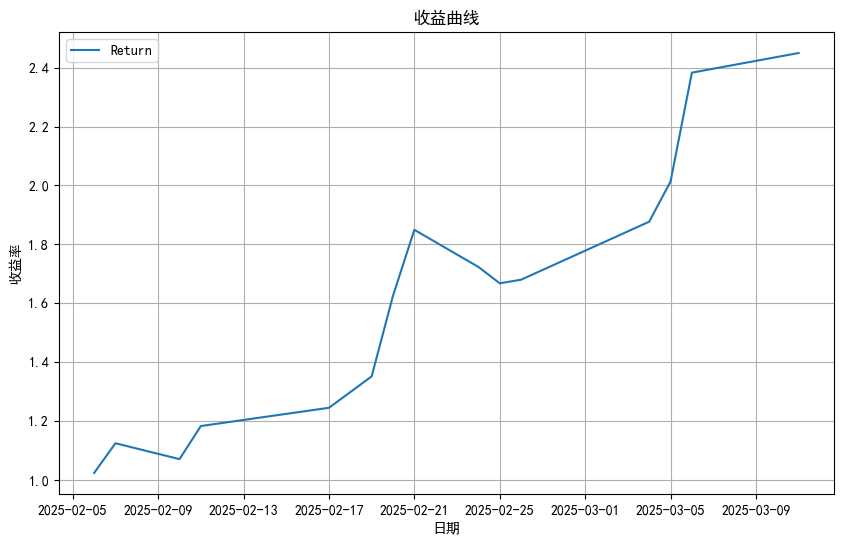

: 

In [ ]:
plot(ddwndx, 'cumulative_returns')

In [ ]:
dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']

In [ ]:
pd.set_option('display.max_columns', None)
dwndx.sort_values(by='r_pct', ascending=False)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_pct
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-07,389,低吸,放宽低吸前3,002397.XSHE,梦洁股份,1,,,,-1,-1,-1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0.0,773.22,513.57,0.0,-0.53,3.74,4.14,-1.0,4.11,4.02,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,-106.84,-11.13,53,-81.72,-20.26,47,2025-02-15 19:24:50,37238259.0,0.098930,0.097930,0.074866,0.073866,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3.87,1.034759
2024-11-29,1819,低吸,放宽低吸前3,001259.XSHE,利仁科技,1,,,,-1,-1,-1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,1616.27,750.96,0.0,-5.81,22.06,23.14,-1.0,23.14,23.26,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,-93.61,1.95,76,2.85,6.84,56,2025-02-15 18:51:18,11791070.0,0.048957,0.047957,0.054397,0.053397,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,22.80,1.033545
2024-11-13,934,低吸,放宽低吸前3,002858.XSHE,力盛体育,1,"000012.BKDL,000003.BKDL,000027.BKDL,000016.BKD...","885933.DDBK,886017.DDBK,886019.DDBK,886062.DDB...","980473.ZHBK,980355.ZHBK,980348.ZHBK",1,1,25,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,517.46,571.53,0.0,0.00,14.26,13.70,-1.0,13.18,12.43,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,68.66,29.41,17,139.09,-2.64,4,2025-02-15 18:36:00,21311570.0,-0.075736,-0.076736,-0.128331,-0.129331,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,14.69,1.030154
2025-02-19,2809,低吸,放宽低吸前3,002123.XSHE,梦网科技,1,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","885757.DDBK,886019.DDBK,886041.DDBK,885816.DDB...","980753.ZHBK,980355.ZHBK,980376.ZHBK",2,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1691.14,1628.36,0.0,-8.16,17.00,19.42,-1.0,18.39,19.03,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,10.48,-60.97,37,-25.50,-28.06,44,2025-02-28 17:27:25,422170724.0,0.081765,0.080765,0.119412,0.118412,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,17.51,1.030000
2025-01-27,1284,低吸,放宽低吸前3,002730.XSHE,电光科技,1,"000003.BKDL,000023.BKDL,000035.BKDL,000006.BKD...","885517.DDBK,885729.DDBK,885700.DDBK,885619.DDB...",980365.ZHBK,2,1,34,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0.0,1673.81,1625.53,0.0,-7.18,23.01,23.05,-1.0,22.82,20.75,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,-90.83,-20.18,68,-124.75,2.63,77,2025-02-15 19:41:44,259005162.0,-0.008257,-0.009257,-0.098218,-0.099218,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,23.70,1.029987
2025-03-04,556,低吸,放宽低吸前3,605100.XSHG,华丰股份,1,"000003.BKDL,000024.BKDL,000023.BKDL,000035.BKD...","885869.DDBK,885887.DDBK,885706.DDBK,885946.DDB...",980365.ZHBK,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,436.78,453.39,0.0,-4.35,22.00,25.30,-1.0,25.00,25.32,-1.0,-1.0,-1.0,-1.0,0,0,9G0099,放宽低吸前3,-114.88,-88.23,55,-57.32,-37.21,58,2025-03-05 08:01:39,40517048.0,0.136364,0.135364,0.150909,0.149909,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,22.64,1.029091
2025-01-24,1233,低吸,放宽低吸前3,002917.XSHE,金奥博,1,"000012.BKDL,000023.BKDL,000018.BKDL,000035.BKD...","885743.DDBK,885517.DDBK,885700.DDBK,885619.DDB...",9803

<Axes: ylabel='Frequency'>

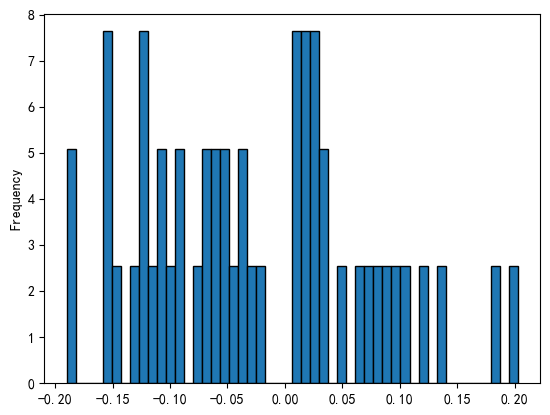

In [ ]:
ddwndx['r_return'].plot(kind='hist', bins=50, density=True, edgecolor='black')

In [ ]:
# 最大回撤: -14.59%
# 夏普比率: 0.29
# 总收益率: 234.78%
# 年化收益率: 722.40%
# 波动率: 5.95%
# 总盈亏: 235.83%
# 成功次数: 48
# 失败次数: 30
# 总天数: 78
# 总交易次数: 78
# 交易频率: 100.00%
# 胜率: 61.54%
# 平均盈利: 4.61%
# 平均亏损: -2.89%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 37.43%

In [ ]:
# return:
# 最大回撤: -14.59%
# 夏普比率: 0.28
# 总收益率: 192.71%
# 年化收益率: 690.29%
# 波动率: 6.32%
# 总盈亏: 194.90%
# 成功次数: 41
# 失败次数: 26
# 总天数: 67
# 总交易次数: 67
# 交易频率: 100.00%
# 胜率: 61.19%
# 平均盈利: 4.87%
# 平均亏损: -3.05%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 36.91%

In [ ]:
# return:
# 最大回撤: -14.83%
# 夏普比率: 0.31
# 总收益率: 192.83%
# 年化收益率: 784.38%
# 波动率: 6.57%
# 总盈亏: 195.02%
# 成功次数: 36
# 失败次数: 23
# 总天数: 59
# 总交易次数: 59
# 交易频率: 100.00%
# 胜率: 61.02%
# 平均盈利: 5.23%
# 平均亏损: -2.96%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.76
# 凯利公式最佳仓位: 38.92%
